In [1]:
import torch
from torch import nn
from d2l import torch as d2l

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)
X_example, y_example = next(iter(train_iter))
print(X_example.shape, y_example.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


第一种模型实现

In [2]:
class LeNet(nn.Module):
        def __init__(self, in_channels):
                super().__init__()
                self.conv2d_1 = nn.Conv2d(in_channels = in_channels, out_channels = 6, 
                                          kernel_size=5, padding = 2)
                self.ac_1 = nn.Sigmoid()
                self.pooling_1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
                self.conv2d_2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5)
                self.ac_2 = nn.Sigmoid()
                self.pooling_2 = nn.AvgPool2d(kernel_size = 2, stride = 2)

                self.flatten = nn.Flatten()
                self.linear_1 = nn.Linear(16 * 5 * 5, 120)
                self.ac_3 = nn.Sigmoid()
                self.linear_2 = nn.Linear(120, 84)
                self.ac_4 = nn.Sigmoid()
                self.linear_3 = nn.Linear(84, 10)

        def forward(self, X):
                output_conv_1 = self.pooling_1(self.ac_1(self.conv2d_1(X)))
                output_conv_2 = self.pooling_2(self.ac_2(self.conv2d_2(output_conv_1)))

                output = self.flatten(output_conv_2)
                output = self.ac_3(self.linear_1(output))
                output = self.ac_4(self.linear_2(output))

                return self.linear_3(output)

net = LeNet(1)
net(X_example).shape
# for i, (X, y) in enumerate(train_iter):
#         X = X.to("cuda")
#         y = y.to("cuda")
#         print(i, X.shape, y.shape, X.device)
#         y_hat = net(X)
#         print(y_hat.shape)

torch.Size([256, 10])

第二种模型实现

In [3]:
class Reshape(nn.Module):
        def forward(self, X):
                return X.view(-1, 1, 28, 28)

net_seq = nn.Sequential(Reshape(), 
                        nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=5, padding = 2), nn.Sigmoid(),
                        nn.AvgPool2d(kernel_size = 2, stride = 2),
                        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size=5), nn.Sigmoid(),
                        nn.AvgPool2d(kernel_size = 2, stride = 2),
                        nn.Flatten(),
                        nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                        nn.Linear(120, 84), nn.Sigmoid(),
                        nn.Linear(84, 10)
                        )

X_example_clone = X_example.clone()
for modules in net_seq:
        X_example_clone = modules(X_example_clone)
        print(modules.__class__.__name__, X_example_clone.shape)

Reshape torch.Size([256, 1, 28, 28])
Conv2d torch.Size([256, 6, 28, 28])
Sigmoid torch.Size([256, 6, 28, 28])
AvgPool2d torch.Size([256, 6, 14, 14])
Conv2d torch.Size([256, 16, 10, 10])
Sigmoid torch.Size([256, 16, 10, 10])
AvgPool2d torch.Size([256, 16, 5, 5])
Flatten torch.Size([256, 400])
Linear torch.Size([256, 120])
Sigmoid torch.Size([256, 120])
Linear torch.Size([256, 84])
Sigmoid torch.Size([256, 84])
Linear torch.Size([256, 10])


In [4]:
def accuracy(y_hat, y):
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
                y_hat = torch.argmax(y_hat, dim = 1)
                
        cmp = d2l.astype(y_hat, y.dtype) == y
        return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

def evaluate_accuracy_gpu(net, data_iter, device = None):
        if isinstance(net, nn.Module):
                net.eval()
                if device is None:
                        device = next(iter(net.parameters())).device
        matrix = d2l.Accumulator(2)
        with torch.no_grad():
                for X, y in data_iter:
                        if isinstance(X, list):
                                X = [i.to(device) for i in X]
                        else:
                                X = X.to(device)
                        y = y.to(device)
                        matrix.add(accuracy(net(X), y), y.numel())

        return matrix[0] / matrix[1]

In [5]:
print(accuracy(net(X_example), y_example))
print(evaluate_accuracy_gpu(net, test_iter))

17.0
0.1


In [10]:
def train_gpu(net, train_iter, test_iter, num_epochs, learning_rate, device):
        def init_weights(m):
                if type(m) == nn.Linear or type(m) == nn.Conv2d:
                        nn.init.xavier_uniform_(m.weight)
                        
        net.apply(init_weights)
        print('training on', device)
        net = net.to(device)
        loss = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
        
        animator = d2l.Animator(xlabel="epochs", legend=["loss", "train_acc", "valid_acc"], xlim=[1, 1 + num_epochs])

        timer, num_batches = d2l.Timer(), len(train_iter)
        for epoch in range(num_epochs):
                matrix = d2l.Accumulator(3)
                net.train()
                for i, (X, y) in enumerate(train_iter):
                        timer.start()
                        
                        optimizer.zero_grad()
                        X = X.to(device)
                        y = y.to(device)
                        y_hat = net(X)
                        l = loss(y_hat, y)
                        l.backward()
                        optimizer.step()
                        with torch.no_grad():
                                matrix.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
                                
                        timer.stop()
                        train_loss = matrix[0] / matrix[2]
                        train_acc = matrix[1] / matrix[2]
                        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                                animator.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None))
                test_acc = evaluate_accuracy_gpu(net, test_iter)
                animator.add(epoch + 1, (None, None, test_acc))
                
        print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
        print(f'{matrix[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
                

loss 0.451, train acc 0.833, test acc 0.813
102459.7 examples/sec on cuda


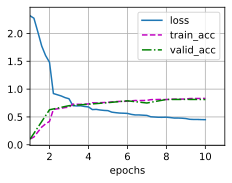

In [12]:
num_epochs, learning_rate = 10, 0.9
device = "cuda"
train_gpu(net, train_iter, test_iter, num_epochs, learning_rate, device)

In [ ]:
len(train_iter)

In [ ]:
torch.cuda.is_available()
